In [1]:
import matplotlib.pylab as plt
import numba

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import Estimation as st
import tables as tb
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import scipy.optimize as sop
import numpy as np
from scipy.special import gamma
from copy import deepcopy
#from Fits import Fi

In [45]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import matplotlib.pylab as plt
import scipy.optimize as sop
import numpy as np
from scipy.special import gammaln
from copy import copy

def generalLogPoisson(x,mu):
    #Çmu[mu<-2e-11] = np.nan
    '''for i in mu:
        if i<-2e-11:
       
       print(i)
    '''
    return (-mu+x*np.log(mu+0.00001)-gammaln(x+1))
    
class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E[:]
        self.spectrum = spectrum.hist[:]
        self.PDFs = copy(PDFs)
        self.PDF_Val = np.array([np.array(pdfi.pdf(E)) for pdfi in self.PDFs])
        
    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        nevs = nevs.reshape(len(nevs),1)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        lm = (np.array(generalLogPoisson(ydat,ypdf))).sum()
        return -2*lm

        
        
    def FitLLM(self,nevs,bounds=None, **kwargs):
        nevs = nevs.reshape(len(np.array(nevs)),1)
        fit = self.LogLikelihood
        res = sop.minimize(fit,nevs,method='Nelder-Mead',**kwargs)
        ypdf = np.sum(nevs*self.PDF_Val,axis=0)
        ydat = self.spectrum
        chi2 = -1
        err = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2/((ydat+0.0001)*(len(ypdf)-len(nevs))))
            err = self.GetError(res.x)
        res.chi2 = chi2
        res.err = err
        return res
    
    def FitLLMScan(self,nevs, fixn, npoint=100, **kwargs):
        nevs = nevs.reshape(len(np.array(nevs)),1)
        aux = nevs[fixn]
        aux_evs = np.delete(nevs,fixn)
        fun_aux = self.FitLLM(nevs, **kwargs).fun
        res_list = []
        for aux_s in np.linspace(0,2*aux,npoint):
            fit = lambda x_nevs: self.LogLikelihood(np.insert(x_nevs,fixn,aux_s))
            #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
            res = sop.minimize(fit,aux_evs,method='Nelder-Mead',**kwargs)
            res_list.append(res.fun-fun_aux)
            #print(aux_s,res)
            if not(res.success):
                print('error')
        return np.linspace(0,2*aux,npoint),res_list
    
    def GetError(self, nevsmin, **kwargs):
        error = []
        nevs = nevsmin.reshape(len(np.array(nevsmin)),1)
        res_list = np.zeros(len(nevsmin))
        ll_min = self.LogLikelihood(nevsmin)
        for fixn in np.arange(len(nevsmin)):
        
            aux = nevs[fixn]
            aux_evs = np.delete(nevs,fixn)          
            fit = lambda aux_s:  (lambda x_nevs: self.LogLikelihood(np.insert(x_nevs,fixn,aux_s)) )
            #res = sop.minimize(fit,nevs,method='L-BFGS-B',bounds = bounds,**kwargs)
            res = lambda aux_ss: (sop.minimize(fit(aux_ss),aux_evs,method='Nelder-Mead',**kwargs)).fun-1-ll_min
            res_list[fixn] = (sop.root(res,aux-aux**0.5).x)[0]          
        return np.abs(nevsmin-res_list)
       
        
    def GetSpectra(self,E,*nevs):
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        #print ypdf
        return ypdf

    def FitLeastSQ(self,nevs,**kwargs):
        nevs = np.array(nevs)
        fit = self.GetSpectra
        res = sop.curve_fit(fit,self.E,self.spectrum, nevs)
        return res


In [4]:
f = tb.open_file("../Data/data_spectrum.h5", "r")

In [5]:
f

File(filename=../Data/data_spectrum.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Bi (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Co (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/E (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/K (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/Tl (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/bb2n (Array(125,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  b

In [6]:
minE,maxE,nbin = 0.6,3.,125
E = f.root.E[:]
Co = f.root.Co[:]
K = f.root.K[:]
Tl = f.root.Tl[:]
Bi = f.root.Bi[:]
bb2n = f.root.bb2n[:]
testnn = f.root.testnn[:]
total = f.root.total[:]

In [7]:
h_Co = hist([],nbin,minE,maxE)
h_Co.hist = Co
h_Co.bins = E
h_K = hist([], nbin,minE,maxE)
h_K.hist = K
h_K.bins = E
h_Tl = hist([],nbin,minE,maxE)
h_Tl.hist = Tl
h_Tl.bins = E
h_Bi = hist([],nbin,minE,maxE)
h_Bi.hist = Bi
h_Bi.bins = E
h_bb2n = hist([],nbin,minE,maxE)
h_bb2n.hist = bb2n
h_bb2n.bins = E
h_testnn = hist(testnn,nbin,minE,maxE)
h_testnn.hist = testnn
h_testnn.bins = E
h_total = hist(total,nbin,minE,maxE)
h_total.hist = total
h_total.bins = E

In [8]:
interpol = 'cubic'
pdf_Co = PDF(h_Co,interpolation=interpol)
pdf_K = PDF(h_K,interpolation=interpol)
pdf_Tl = PDF(h_Tl,interpolation=interpol)
pdf_Bi = PDF(h_Bi,interpolation=interpol)
pdf_bb2n = PDF(h_bb2n,interpolation=interpol)
pdf_testnn = PDF(h_testnn,interpolation=interpol)
pdf_total = PDF(h_total,interpolation=interpol)

In [9]:
pdflis = [pdf_Co,pdf_K,pdf_Tl,pdf_Bi,pdf_bb2n]
nevslist = np.array([150000,80000,15000,40000,20000])/8.

In [10]:
fit = Fit(E,h_total,pdflis)

In [11]:
%time res_ll = fit.FitLLM(nevslist,tol=1e-10,options={"maxiter":100000,'ftol':1e-20})
#"gtol":1e-12, ,'maxls':50

CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.67 s


In [12]:
res_ll

          chi2: 1.7545517115556524
           err: array([ 321.84053591,  268.4997368 ,  107.99618617,  485.68737027,
        443.11965811])
 final_simplex: (array([[ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794],
       [ 18395.0973629 ,  10041.57996118,   1992.7751794 ,   4838.85734773,
          1384.68928794]]), array([ 715.13490661,  715.13490661,  715.13490661,  715.13490661,
        715.13490661,  715.13490661]))
           fun: 715.134906606767
       message: 'Optimization terminated successfully.'
          nfev: 560
           ni

In [13]:
nevslist

array([ 18750.,  10000.,   1875.,   5000.,   2500.])

In [14]:
%time res_ls = fit.FitLeastSQ(nevslist,tol=1e-12,options={"maxiter":1000})

CPU times: user 1.21 s, sys: 32.5 ms, total: 1.24 s
Wall time: 1.32 s


In [15]:
for i in range(len(res_ls[0])):
    print(res_ls[0][i],' +- ', (res_ls[1][i,i])**0.5)

18967.8383795  +-  297.667231852
10149.6005837  +-  248.442467245
2634.76085786  +-  397.014502889
4478.6278918  +-  312.113365883
540.682346863  +-  478.157932923


# Errors

/home/brais/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log


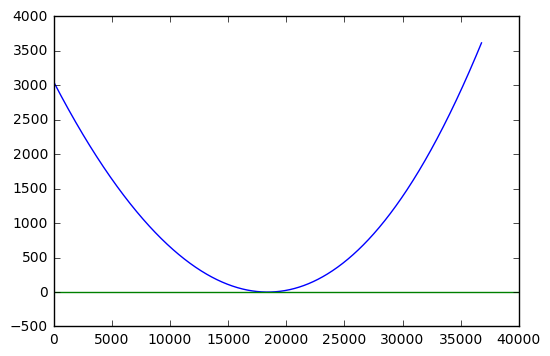

In [16]:
scan = fit.FitLLMScan(np. array([ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,1384.77826122]),0,1000)
plt.plot(scan[0],np.array(scan[1])-1)
plt.plot([0,40000],[0,0])

(-0.5, 0.5)

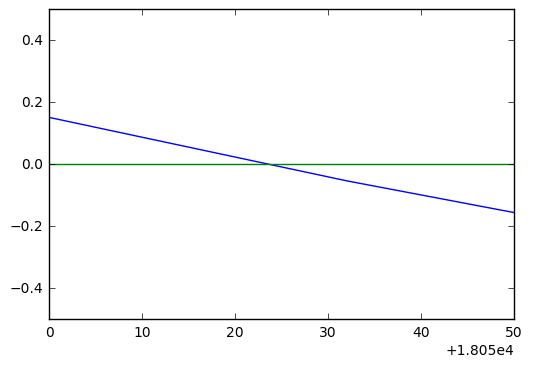

In [17]:
plt.plot(scan[0],np.array(scan[1])-1)
plt.plot([0,40000],[0,0])
plt.xlim(18050,18100)
plt.ylim(-.5,.5)

In [18]:
%time a = fit.GetError(np.array([ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,1384.77826122]))

CPU times: user 2.04 s, sys: 4.01 ms, total: 2.04 s
Wall time: 2.04 s


In [19]:
a

array([ 321.7733382 ,  268.46084757,  107.75297585,  485.84817231,
        443.20986332])

In [20]:
np.array([ 18395.02927031,  10041.54032921,   1992.53167288,   4839.01680656,1384.77826122])**0.5

array([ 135.62827607,  100.20748639,   44.63778302,   69.56304196,
         37.2126089 ])

In [21]:
N = 100
nx = np.linspace(0,result[i]*2,N)
LL = []
chi = []
for ni in nx:
    res = fit.FitLLMScan(nevslist,ni,tol=1e-8,options={"maxiter":1000})
    LL.append(res.fun)
    chi.append(res.chi2)
    print(ni,'\n',res,'\n \n')

NameError: name 'result' is not defined

In [22]:
plt.plot(nx,LL)
#plt.plot(nx,chi)


NameError: name 'nx' is not defined

In [23]:
N = 50
for i in range(5):
    nevs = np.copy(result)
    x = np.linspace(0,result[i]*3,N)
    y = np.zeros([N,1])
    for event in range(len(x)):
        nevs[i] = x[event]
        y[event] = fit.LogLikelihood(nevs)
    plt.plot(x,y-357.46490713137422-2)
    plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-2,'o')
plt.plot([0,60000],[0,0])

NameError: name 'result' is not defined

In [24]:
plt.plot(x,y-357.46490713137422-0.5)
plt.plot(result[i],fit.LogLikelihood(result)-357.46490713137422-0.5,'o')
plt.plot([x[0],x[-1]],[0,0])
plt.xlim(1225,1226)
plt.ylim(-0.005151,0.0051)
#for i in 

NameError: name 'x' is not defined

# Pulls

In [25]:
nevslist = np.array([150000,80000,15000,40000,20000])/8
ne = np.array([0,0,0,0,0])
h_Coaux = hist([],nbin,minE,maxE)
h_Coaux.hist = Co/8.
ne[0] = h_Coaux.hist.sum()
h_Coaux.bins = E
h_Kaux = hist([], nbin,minE,maxE)
h_Kaux.hist = K/.8
ne[1] = h_Kaux.hist.sum()
h_Kaux.bins = E
h_Tlaux = hist([],nbin,minE,maxE)
h_Tlaux.hist = Tl/8.
ne[2] = h_Tlaux.hist.sum()
h_Tlaux.bins = E
h_Biaux = hist([],nbin,minE,maxE)
h_Biaux.hist = Bi/8.
ne[3] = h_Biaux.hist.sum()
h_Biaux.bins = E
h_bb2naux = hist([],nbin,minE,maxE)
h_bb2naux.hist = bb2n*2054/bb2n.sum()
ne[4] = h_bb2naux.hist.sum()
h_bb2naux.bins = E

In [26]:
print(nevslist,ne)

[ 18750.  10000.   1875.   5000.   2500.] [18622 99495  1902  4786  2054]


In [59]:
haux =  hist([], nbin,minE,maxE)
nevslist = np.array([150000,80000,15000,40000,20000])/8.
N_pull = 100
pull_list = np.zeros([N_pull])
ne_poiss = np.zeros([5])
for i in np.arange(N_pull):
    aux = np.random.poisson(h_Coaux.hist)
    ne_poiss[0] = aux.sum()
    haux.hist = aux
    aux = np.random.poisson(h_Kaux.hist)
    ne_poiss[1] = aux.sum()
    haux.hist += aux
    aux = np.random.poisson(h_Tlaux.hist)
    ne_poiss[2] = aux.sum()
    haux.hist += aux
    aux = np.random.poisson(h_Biaux.hist)
    ne_poiss[3] = aux.sum()
    haux.hist += aux
    aux = np.random.poisson(h_bb2naux.hist)
    ne_poiss[4] = aux.sum()
    haux.hist += aux

    fit = Fit(E,haux,pdflis)
    res = fit.FitLLM(ne)
    print(i,"\n",res.x,"\n",ne_poiss,"\n",res.err)

0 
 [ 18504.88027903  99877.44102625   1604.37800181   5822.75643055
   1280.54354033] 
 [ 18898.  99568.   1849.   4719.   2056.] 
 [ 575.91280312  627.78553821  104.36085604  654.16409778  598.66489069]
1 
 [ 18457.14750228  99528.53352656   1810.94706061   4382.44581192
   2078.92551824] 
 [ 18567.  99252.   1835.   4636.   1968.] 
 [ 573.19589002  627.12524066  107.27055976  629.38109756  583.3185856 ]
2 
 [  18388.32926213  100031.24247509    2120.30833367    4205.56219616
    1798.55665352] 
 [ 18456.  99398.   1910.   4736.   2044.] 
 [ 573.14536119  627.81288136  114.0369689   643.39699386  596.34112481]
3 
 [ 18423.01437625  98876.2537937    1926.83384024   4231.89824107
   2905.99844751] 
 [ 18396.  99159.   1974.   4763.   2072.] 
 [ 576.31286434  628.33353739  108.12782972  644.96120678  600.40635577]
4 
 [  18281.04756785  100544.85915345    1915.43613751    5090.6982325
    1400.95763243] 
 [  18553.  100076.    1888.    4720.    1996.] 
 [ 578.98152542  630.40867948  108

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

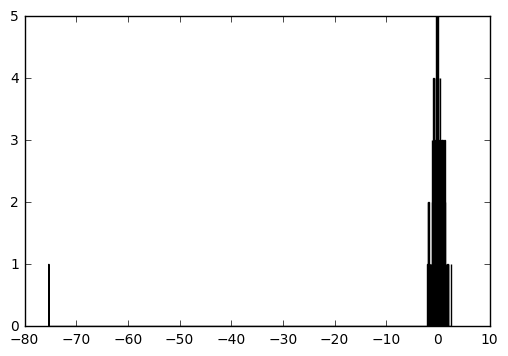

In [50]:
plt.hist(pull_list[:,4],bins = 1000)

In [48]:
np.mean(pull_list[:,4])

-0.86691857044792353

In [116]:
print(ne_poiss)

[ 0.  0.  0.  0.  0.]


In [30]:
pull_list[:,0]

array([ 0.7745864 ,  0.16113402, -1.26400546,  0.62567355,  0.82198558,
        0.12768594, -2.26215798,  0.90540747, -0.17587497,  0.32103691,
        0.27305863, -0.18377074,  1.15098343,  0.38271187, -1.78523931,
       -0.77421255, -0.84876089,  0.07665809,  1.43761751,  1.07145009,
        0.14012544, -0.42914055,  0.27045366,  1.27402826,  0.47026773,
        0.2411996 ,  0.85228809, -0.20766696,  0.04607264,  0.08207128,
        2.20028887,  0.67213155,  2.29087097, -0.51628877,  1.59079347,
        0.15899259,  0.05959463, -0.03899149,  0.74056403, -0.28999704,
       -0.98897814,  0.51998174,  1.01365508,  0.58263626,  1.29851988,
        0.28112019, -0.447634  ,  0.26676989, -0.63212137,  1.40190262,
       -0.71428155, -1.01359082,  1.75336855,  0.55753255,  0.40650953,
       -1.57411584, -1.21024924, -0.7392018 ,  0.35500622, -1.21753132,
        0.65550086,  1.47972578, -0.77480968,  0.44594448,  0.58087772,
       -0.70937425, -1.96490591,  1.12179841,  0.36284198, -1.32

# Plot

In [ ]:
result = np.array([18395.02975447, 10041.5398816, 1992.53178756, 4839.01641257, 1384.7787113])

In [ ]:
interpol = 'nearest'
pdf_CoP = PDF(h_Co,factor=result[0],interpolation=interpol)
pdf_KP = PDF(h_K,factor=result[1],interpolation=interpol)
pdf_TlP = PDF(h_Tl,factor=result[2],interpolation=interpol)
pdf_BiP = PDF(h_Bi,factor=result[3],interpolation=interpol)
pdf_bb2nP = PDF(h_bb2n,factor=result[4],interpolation=interpol)



In [ ]:
Ep = np.linspace(0.6,2.8,1000)
aux =(E>0.6)&(E<2.8)
Ea = E[aux]
totala = total[aux]
testnna = testnn[aux]
y_CoP = pdf_CoP.pdf(Ep)
y_KP = pdf_KP.pdf(Ep)
y_TlP = pdf_TlP.pdf(Ep)
y_BiP = pdf_BiP.pdf(Ep)
y_bb2nP = pdf_bb2nP.pdf(Ep)
fittotal = y_CoP+y_KP+y_TlP+y_BiP+y_bb2nP
y_CoP[0]=0.00001
y_CoP[-1]=0.00001
y_KP[0]=0.00001
y_KP[-1]=0.00001
y_BiP[0]=0.00001
y_BiP[-1]=0.00001
y_TlP[0]=0.00001
y_TlP[-1]=0.00001


In [ ]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [ ]:
alfa= 0.2
plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)

plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [ ]:
alfa= 0.2
#plt.semilogy()
plt.ylim(0.5,3e3)
plt.errorbar(Ea,totala,yerr=np.sqrt(totala),marker='.',elinewidth=1,
             linewidth=0,label='data',color='black')
plt.errorbar(Ea,testnna,yerr=np.sqrt(testnna),marker='.',elinewidth=1,
             linewidth=0,label='bb2n_data',color='m')
plt.plot(Ep,fittotal,label='fit')
plt.plot(Ep,y_bb2nP,label='bb2n_fit')
plt.fill_between(Ep,0,y_CoP,label='Co_fit',alpha=alfa,color='r')
plt.fill_between(Ep,0,y_KP,label='K_fit',alpha=alfa,color='g')
plt.fill_between(Ep,0,y_TlP,label='Tl_fit',alpha=alfa,color='y')
plt.fill_between(Ep,0,y_BiP,label='Bi_fit',alpha=alfa,color='b')
#plt.plot(E)
plt.gcf().set_size_inches(12,9)
plt.legend().get_frame().set_facecolor('0.95')
plt.xlabel('Energy (MeV)',fontsize=16)
plt.ylabel('Entries',fontsize=18)
plt.savefig('fitspectrum.pdf')

In [ ]:
total.sum()

In [ ]:
result.sum()